In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

# Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Neelay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Neelay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Load dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_train.data
labels = newsgroups_train.target
label_names = newsgroups_train.target_names

In [3]:
# EDA
# Dataset summary
print("Number of documents:", len(documents))
print("Number of categories:", len(label_names))
print("Categories:", label_names)

Number of documents: 11314
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


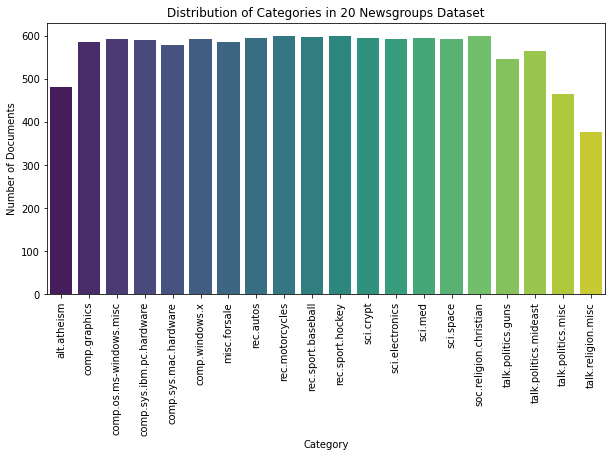

In [4]:
# Distribution of categories
category_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.title('Distribution of Categories in 20 Newsgroups Dataset')
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.show()

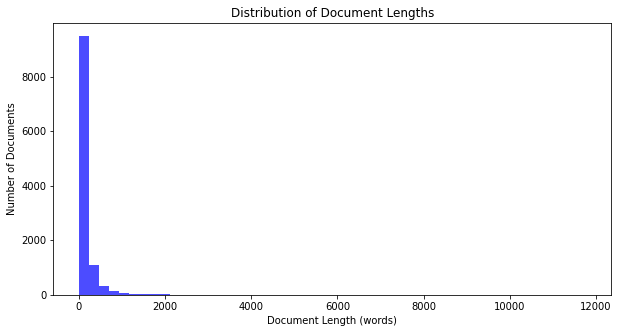

In [5]:
# Document length analysis
document_lengths = [len(doc.split()) for doc in documents]
plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Document Length (words)')
plt.ylabel('Number of Documents')
plt.title('Distribution of Document Lengths')
plt.show()

In [6]:
# Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

documents = [preprocess(doc) for doc in documents]

In [7]:
# Vectorization
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)

In [8]:
# LDA (Gensim)
# Explanation: LDA (Latent Dirichlet Allocation) is a generative probabilistic model that assumes each document is a mixture of topics and each topic is a mixture of words.
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
lda_model_gensim = LdaModel(corpus, num_topics=10, id2word=id2word, passes=10)

In [9]:
# LDA (scikit-learn)
# Explanation: Another implementation of LDA using scikit-learn which follows the same probabilistic approach.
lda_model_sklearn = LatentDirichletAllocation(n_components=10, random_state=0)
lda_topics_sklearn = lda_model_sklearn.fit_transform(X)

In [10]:
# NMF
# Explanation: NMF (Non-negative Matrix Factorization) is a linear algebra technique that factorizes the document-term matrix into non-negative matrices. It’s useful for parts-based representation.
nmf_model = NMF(n_components=10, random_state=0)
nmf_topics = nmf_model.fit_transform(X)

In [11]:
# LSA (TruncatedSVD)
# Explanation: LSA (Latent Semantic Analysis) uses SVD (Singular Value Decomposition) to reduce the dimensionality of the document-term matrix, capturing the underlying structure in the data.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(documents)
lsa_model = TruncatedSVD(n_components=10, random_state=0)
lsa_topics = lsa_model.fit_transform(X_tfidf)

In [12]:
# Evaluation (Coherence Score for LDA)
# Explanation: Coherence score measures the quality of the topics. Higher coherence scores indicate more interpretable topics.
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=[doc.split() for doc in documents], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [13]:
# Print top words for each topic for each model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [14]:
n_top_words = 10

In [15]:
print("LDA Topics (scikit-learn):")
print_top_words(lda_model_sklearn, vectorizer.get_feature_names_out(), n_top_words)

print("NMF Topics:")
print_top_words(nmf_model, vectorizer.get_feature_names_out(), n_top_words)

print("LSA Topics:")
print_top_words(lsa_model, tfidf_vectorizer.get_feature_names_out(), n_top_words)

print(f"LDA Coherence Score (Gensim): {coherence_lda}")

LDA Topics (scikit-learn):
Topic #0:
game team year games play season players hockey good new
Topic #1:
people government gun years states said new health control public
Topic #2:
max bhj giz wm ah gk bj ax bh air
Topic #3:
file use available program information files window data version image
Topic #4:
output file entry program dod rules new int printf line
Topic #5:
space president launch nasa years program april year satellite money
Topic #6:
drive thanks like card use know windows problem disk need
Topic #7:
key encryption government chip armenian security keys clipper israel privacy
Topic #8:
like car know said time people right good think way
Topic #9:
god people think know say like believe jesus time good

NMF Topics:
Topic #0:
max bhj giz gk bj wm qax kn ax nrhj
Topic #1:
db mov cs bh byte al si di bl bits
Topic #2:
image jpeg available version data use software images file widget
Topic #3:
people said know like say time went god think came
Topic #4:
output file entry oname pro

In [16]:
lda_vis = gensimvis.prepare(lda_model_gensim, corpus, id2word)
pyLDAvis.save_html(lda_vis, 'lda_gensim.html')

/Users/Neelay/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [17]:
# Wordclouds for top words in each model
def plot_wordcloud(model, feature_names, title):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, max_words=50, colormap='viridis').generate_from_frequencies(dict(zip(feature_names, model.components_.flatten())))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

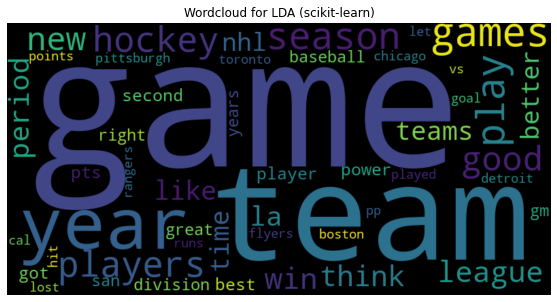

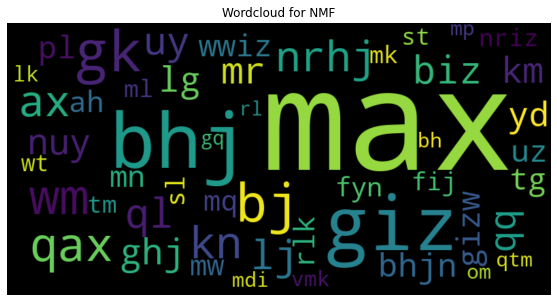

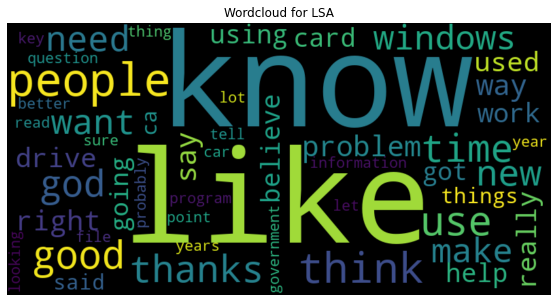

In [18]:
plot_wordcloud(lda_model_sklearn, vectorizer.get_feature_names_out(), "Wordcloud for LDA (scikit-learn)")
plot_wordcloud(nmf_model, vectorizer.get_feature_names_out(), "Wordcloud for NMF")
plot_wordcloud(lsa_model, tfidf_vectorizer.get_feature_names_out(), "Wordcloud for LSA")

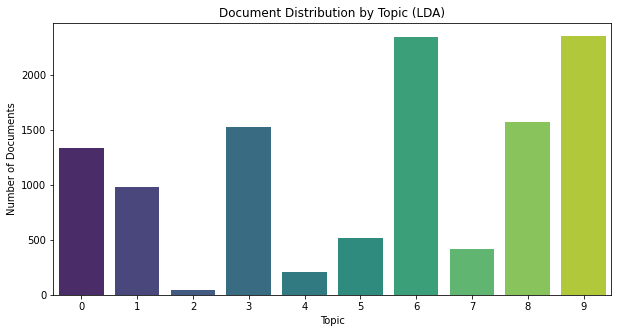

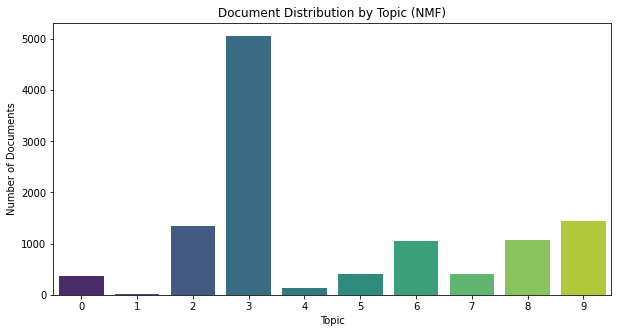

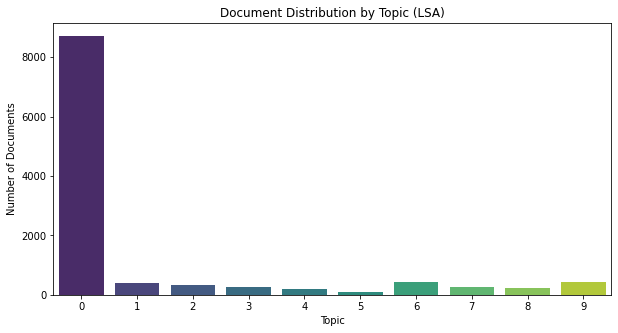

In [21]:
# Document distribution by topic for each model
def plot_topic_distribution(model, topics, title):
    topic_distribution = topics.argmax(axis=1)
    topic_counts = pd.Series(topic_distribution).value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
    plt.xlabel('Topic')
    plt.ylabel('Number of Documents')
    plt.title(title)
    plt.show()

plot_topic_distribution(lda_model_sklearn, lda_topics_sklearn, "Document Distribution by Topic (LDA)")
plot_topic_distribution(nmf_model, nmf_topics, "Document Distribution by Topic (NMF)")
plot_topic_distribution(lsa_model, lsa_topics, "Document Distribution by Topic (LSA)")
